# Demo Convolutional Neural Network (CNN o ConvNet) para clasificar Naves Imperiales de Star Wars en base a su imagen

In [ ]:
#@title Librerías a usar
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.utils import plot_model

import random

import keras.backend as K
from tensorflow.keras.preprocessing import image
import cv2
import copy

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import math
from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import ipywidgets as widgets
from ipywidgets import Box, Layout

print("Librerías cargadas")

Librerías cargadas


##Imágenes:

In [ ]:
# @title Acceder al Drive {"single-column":true}

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = '/content/gdrive/MyDrive/demosColab/demoStarWars//imagenes' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


> Para Entrenamiento: 
- Clases cargadas:  12
- Imágenes cargadas:  5952
- Ejemplo  Command Ships   (64, 64, 3) : 


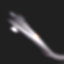



> Para Prueba: 
- Clases cargadas:  12
- Imágenes cargadas:  1488
- Ejemplo  Command Ships   (64, 64, 3) : 


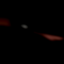

In [ ]:
#@title Cargar imágenes

#@markdown ### Parámetros para imágenes:
imagen_ancho =  64#@param {type:"integer"}
imagen_alto =  64#@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}

# tamaño de las imágenes
if imagen_ancho<=10:
  imagen_alto = 10
if imagen_alto<=10:
  imagen_alto = 10
IMAGE_SHAPE = (imagen_ancho, imagen_alto, (3 if imagen_color else 1))

# carga imagen y prepara como vector
def cargarImagen(imagePathFN):
  global IMAGE_SHAPE
  # abre la imagen
  imag = Image.open(imagePathFN)
  # ajusta Escala Grises/RGB
  if IMAGE_SHAPE[2]==1:
    tipoImage = 'L'
  else:
    tipoImage = 'RGB'
  imag = imag.convert(tipoImage)
  # ajusta tamaño
  imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)
  # transforma a un vector de nros
  arImag = np.array(imag)
  return arImag

# función para cargar las imágenes de árbol de directorios o raiz
def cargarImagenesPath(imagPath, mostrarImg=False, recursive=True, limitarCantDir=None, className=None):
  classes_ori = []
  images_ori = []
  all_els = os.listdir( imagPath )
  all_els.sort()
  for each_el in all_els:
      auxiPath = imagPath + '/' + each_el

      # se fija si es imagen
      if ( each_el.endswith('.png') or each_el.endswith('.jpg') or each_el.endswith('.jpeg') ):
          # carga la imagen
          imag = cargarImagen(auxiPath)
          images_ori.append( imag )
          # determina nombre clase
          if className is None:
            clase =  os.path.splitext(each_el)[0]
          else:
            clase = className
          classes_ori.append( clase )
          # muestra
          if mostrarImg:
            print("\n", clase)
            display( imag )
          # finaliza si llego al máximo limitado
          if (limitarCantDir is not None) and (len(classes_ori) >= limitarCantDir):
              break

      # si es subdirectorio
      elif recursive and os.path.isdir( auxiPath ):
        # procesa subdirectorio recursivo
        auxi_imag, auxi_class = cargarImagenesPath(imagPath=auxiPath,
                                                   mostrarImg=mostrarImg, recursive=recursive,
                                                   limitarCantDir=limitarCantDir,
                                                   className=each_el)
        images_ori.extend(auxi_imag)
        classes_ori.extend(auxi_class)

  return np.array(images_ori), classes_ori

# carga las imagenes de entrenamiento
images_train, classes_train  = cargarImagenesPath(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(np.unique(classes_train)))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0] ) )

# carga las imagenes de prueba
images_test, classes_test  = cargarImagenesPath(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(np.unique(classes_test)))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0]) )

> se considera problema de CLASIFICACIÓN 
-- Utiliza valores alfanuméricos como clase.
** Se detectaron más de 10 clases, revise los datos y el tipo de problema seleccionado!

> Definición de CLASES: 
 - dictMapeo ( 12 ):  ['0 : Command Ships', '1 : Heavy Ships', '2 : Landing Craft', '3 : Medium Ships', '4 : Other Starfighters', '5 : Patrol Craft', '6 : Shuttles', '7 : TIE Bombers', '8 : TIE Experimental Craft', '9 : TIE Fighters', '10 : TIE Support Craft', '11 : Transporters']

> Datos para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (5952, 64, 64, 3)
 - y_train (cant):  5952
     Command Ships [ 0 ]: 496
     Heavy Ships [ 1 ]: 496
     Landing Craft [ 2 ]: 496
     Medium Ships [ 3 ]: 496
     Other Starfighters [ 4 ]: 496
     Patrol Craft [ 5 ]: 496
     Shuttles [ 6 ]: 496
     TIE Bombers [ 7 ]: 496
     TIE Experimental Craft [ 8 ]: 496
     TIE Fighters [ 9 ]: 496
     TIE Support Craft [ 10 ]: 496
     Transporters [ 11 ]: 496

 Datos para Prueba: 
 - x_test (

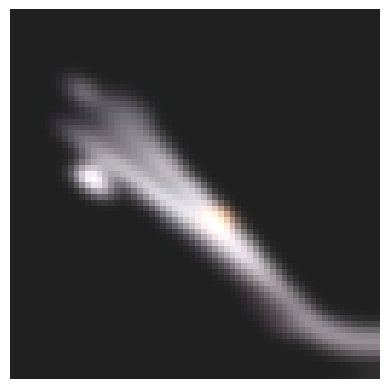

In [ ]:
#@title Preparar imágenes

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "discreto - CLASIFICACION" #@param ["discreto - CLASIFICACION", "continuo - ESTIMACION"]


# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8)) ## *255
    plt.gray()
  else:
    plt.imshow((imag).reshape(IMAGE_SHAPE).astype(np.uint8)) ## *255
  plt.axis("off")

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):
  auxiAr = np.array(imagList) ##.astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
  return auxiAr

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# inicializa listas
x_train, x_test, y_train, y_test = [], [], [], []
y_trainEnc, y_testEnc = [], []

# control aque haya datos definidos
assert (images_train is not None), "No se cargaron las imágenes de entrada para entrenamiento!"
assert (len(images_train)>0), "No se cargaronlas imágenes de entrada para entrenamiento!"
assert (classes_train is not None), "No se cargaron datos de atributo clase para entrenamiento!"
assert (len(classes_train)>0), "No se cargaron datos de atributos de entrada para entrenamiento!"
assert (images_test is not None), "No se cargaron las imágenes de entrada para prueba!"
assert (len(images_test)>0), "No se cargaronlas imágenes de entrada para prueba!"
assert (classes_test is not None), "No se cargaron datos de atributo clase para prueba!"
assert (len(classes_test)>0), "No se cargaron datos de atributo clase para prueba!"

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

CLASES = []
if esProblemaClasificacion:
  ## CLASIFICAR
  print("> se considera problema de CLASIFICACIÓN ")
  # toma los valores de clase orginales del archivo
  if str(classes_train[0]).replace(".","").isnumeric():
      # Y son números
      print("-- Utiliza valores numéricos como clase.")
      maxValorClase = int(np.max(np.array(classes_train).astype(int)))
      for val in range(maxValorClase+1):
        CLASES.append( "clase {:>3}".format(val) )
      # cambia valores para que sean enteros
      y_train = [ int(y) for y in classes_train]
      y_test = [ int(y) for y in classes_test]
  else:
      # Y no son números
      print("-- Utiliza valores alfanuméricos como clase.")
      CLASES = list(set(classes_train))
      CLASES.sort()
      # cambia valores para que sean enteros
      y_train = [ CLASES.index(y) for y in classes_train]
      y_test = [ CLASES.index(y) for y in classes_test]
  # controla, con advertencias
  if len(CLASES) == 0:
    print("** No se encontraron clases!\n")
  elif len(CLASES) > 10:
    print("** Se detectaron más de 10 clases, revise los datos y el tipo de problema seleccionado!\n")
  # genera salida codificada para softMax
  y_trainEnc = to_categorical(y_train)
  y_testEnc = to_categorical(y_test)
  # muestra resultados
  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", [ str(i) + " : " +CLASES[i]  for i in range(len(CLASES)) ] )
else:
  ## ESTIMAR
  print("> se considera problema de ESTIMACIÓN ")
  if (str(classes_train[0]).replace(".","").isnumeric()):
    # valors numéricos
    print("-- Utiliza valores numéricos de atributo clase.")
    # cambia valores para que sean enteros
    y_train = [ int(y) for y in classes_train]
    y_test = [ int(y) for y in classes_test]
  else:
    # valores alfanuméricos
    print("-- Detecta valores alfanuméricos en atributo clase -> convierte a numéricos: ")
    CLASES = list(set(classes_train))
    CLASES.sort()
    # cambia valores para que sean enteros
    y_train = [ CLASES.index(y) for y in classes_train]
    y_test = [ CLASES.index(y) for y in classes_test]
    print(" - dictMapeo (", len(CLASES), "): ", [ str(i) + " : " +CLASES[i]  for i in range(len(CLASES)) ] )

# convierte a numpy para usar por modelo
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# muestra ejemplos
print("\n> Datos para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    print("    ", CLASES[i], "[", i, "]:", np.sum(y_train == i))

print("\n Datos para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    print("    ", CLASES[i], "[", i, "]:", np.sum(y_test == i))
print("")


if len(y_train)>0:
  if esProblemaClasificacion:
    print("\n - Ejemplo imagen reconstruida de clase", CLASES[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  else:
    print("\n - Ejemplo imagen reconstruida de valor", y_train[0] )
  plot_image(x_train[0])



##Modelo:

In [ ]:
#@title Establecer capas de Image Augmentation (opcional)

aplicar_da_preProcesamiento = False #@param {type:"boolean"}

#@markdown Nota: estas capas se agregan al modelo para generar automaticamente data augmentation sólo durante el entrenamiento.
da_preProcesamiento_RandomFlip_Horizontal = True #@param {type:"boolean"}
da_preProcesamiento_RandomFlip_Vertical = True #@param {type:"boolean"}
da_preProcesamiento_RandomTranslation_Horizontal_factor = 0.5 #@param {type:"number"}
da_preProcesamiento_RandomTranslation_Vertical_factor = 0.5 #@param {type:"number"}
da_preProcesamiento_RandomRotation_factor = 0.5 #@param {type:"number"}
da_preProcesamiento_RandomZoom_factor = 0.5 #@param {type:"number"}
da_preProcesamiento_RandomContrast_factor = 0.5 #@param {type:"number"}
da_preProcesamiento_RandomBrightness_factor = 0.5 #@param {type:"number"}

daLayers_modelo = []

# capas de data augmentation (solo para training)
if aplicar_da_preProcesamiento:

  if da_preProcesamiento_RandomFlip_Horizontal or da_preProcesamiento_RandomFlip_Vertical:
      if da_preProcesamiento_RandomFlip_Horizontal:
        modeDAFlip = "horizontal"
        if da_preProcesamiento_RandomFlip_Vertical:
          modeDAFlip = modeDAFlip + "_and_vertical"
      else:
        modeDAFlip = "vertical"
      daLayers_modelo.append( tf.keras.layers.RandomFlip(mode=modeDAFlip, seed=None, name="da_rndFlip_"+modeDAFlip) )

  if (da_preProcesamiento_RandomTranslation_Horizontal_factor != 0.0) or (da_preProcesamiento_RandomTranslation_Vertical_factor != 0.0):
    daLayers_modelo.append( tf.keras.layers.RandomTranslation(height_factor=da_preProcesamiento_RandomTranslation_Vertical_factor/100, width_factor=da_preProcesamiento_RandomTranslation_Horizontal_factor, name="da_rndTranslation", fill_mode="nearest") )

  if da_preProcesamiento_RandomRotation_factor != 0.0:
      daLayers_modelo.append( tf.keras.layers.RandomRotation(factor=da_preProcesamiento_RandomRotation_factor, name="da_rndRotation", fill_mode="nearest") )

  if da_preProcesamiento_RandomZoom_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomZoom(height_factor=da_preProcesamiento_RandomZoom_factor, name="da_rndZoom", fill_mode="nearest") )

  if da_preProcesamiento_RandomContrast_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomContrast(factor=da_preProcesamiento_RandomContrast_factor, name="da_rndContrast", dtype='float32') )

  if da_preProcesamiento_RandomBrightness_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomBrightness(factor=da_preProcesamiento_RandomBrightness_factor, name="da_rndBrightness") )

# Visualize images and augmentations
cantCapasDA = len(daLayers_modelo) + 2
if cantCapasDA <= 2:
  print("No se aplican capas de Image Augmentation.")
else:
  print("Ejemplo de posibles aplicaciones:")
  fig, ax = plt.subplots(cantCapasDA, 5, figsize=(15,cantCapasDA*3))

  j = 0
  for j in range(5):

    # toma al azar las imágenes a mostrar
    posIm = random.randint(1, len(x_train))
    im = x_train[posIm-1]

    # muestra imagen original
    ax[0][j].imshow((im.astype("uint8")))
    if j == 0:
      ax[0][j].set_title("original")
    ax[0][j].axis('off')

    # muestra imagen con aplicación de capa
    i = 1
    for da_lay in daLayers_modelo:
            ax[i][j].imshow(da_lay( im/1.0 ).numpy().astype("uint8"))
            if j == 0:
              ax[i][j].set_title("sólo capa " + da_lay.name)
            ax[i][j].axis('off')
            i = i + 1

    # aplica todas las capas
    for da_lay in daLayers_modelo:
        im = da_lay(im)

    ax[i][j].imshow(im.numpy().astype("uint8"))
    if j == 0:
      ax[i][j].set_title("TODAS LAS CAPAS")
    ax[i][j].axis('off')

    j = j + 1

  plt.show()

No se aplican capas de Image Augmentation.


In [ ]:
#@title Establecer Modelo


#@markdown ### Parámetros de las capas ConvNet:
convNet_cantidad_capas =  3#@param {type:"integer"}
convNet_tipo_funcion = 'relu' #@param ['exponential', 'linear', 'relu', 'sigmoid', 'tanh' ]
convNet_kernel_tamaño_N =  3 #@param {type:"integer"}
convNet_pooling_tamaño_M = 3 #@param {type:"integer"}
convNet_pooling_tipo = 'Avg_Pooling' #@param ["Max-Pooling", "Avg_Pooling"]
convNet_reshape_lineal = 'Flatten' #param ["Flatten", "GlobalAveragePooling"]

#@markdown ### Parámetros de las capas Lineales:
lineal_cant_neuronas_capas_ocultas = '42, 12' #@param {type:"string"}
lineal_tipo_funcion = 'relu' #@param ['exponential', 'linear', 'relu', 'sigmoid', 'tanh' ]
#markdown (Nota: se puede indicar Cantidad de neuronas, D para DropOut, BN para BatchNormalization)
lineal_porc_capa_DropOut = 0.3 #param {type:"number"}
rna_tipo_capa_salida = 'softmax-MultiClase' #@param ["identidad-Numero", "softmax-MultiClase"]

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "RMSprop", "Momentum", "NAG", "Nadam"]
opt_learning_rate = 0.001 #@param {type: "number"}

## controla los parámetros elegidos

# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
if esProblemaClasificacion:
  tipo_output_softMax = (rna_tipo_capa_salida[:7] == 'softmax')
else:
  print("-- se considera salida lineal porque es problema de Estimación!")
  tipo_output_softMax = False


### funciones auxiliares para crear modelo ###

# agrega capa entrada
def agregarCapaEntradaImg(image_shape):
  return tf.keras.layers.Input(shape=image_shape, name='input_img')

# agrega capas Conv2D + MaxPooling
def agregarCapasConvolucionalesImg(eachLay, cant_capas, tipo_funcion="relu", kernel_shape_N=1, pooling_shape_M=1, pooling_type="M", reshape_type="F"):
  # controla cantidad de capas cnn
  if cant_capas<1:
    # si cantidad menor que 1 no agrega
    print("No se agregan capas convolucionales!")
    return eachLay
  # valida capa anterior
  assert eachLay is not None, "Capa anterior no definida!"
  # valida kernel y pool shape
  cnn_kernel_shape = ( max(kernel_shape_N, 1) )
  cnn_pooling_shape = ( max(pooling_shape_M, 1) )
  # determina pool type
  if pooling_type == 'A':
    cnn_pooling_type = tf.keras.layers.AveragePooling2D
  else:
    cnn_pooling_type = tf.keras.layers.MaxPooling2D
  # agrega capas convolucionales
  auxId = 0
  for i in range(cant_capas, 0, -1):
      # define automática cantidad de filtros
      # para que decrementen por capa según recomendación
      cnn_filters =  2**(i+2)
      # define el nombre de la capa oculta
      auxId += 1
      auxlayerName = 'conv_'+str(auxId)
      # agrega las capas ocultas de tipo Conv2D + MaxPooling
      eachLay =  tf.keras.layers.Conv2D(cnn_filters,
                                        cnn_kernel_shape,
                                        activation=tipo_funcion,
                                        padding='same',
                                        name=auxlayerName+'_cf')(eachLay)
      # determina nombre y shape de la capa conv2D
      last_conv_layer_name = 'c_'+auxlayerName
      last_conv_layer_shape = (eachLay.shape[1], eachLay.shape[2])
      ##print(last_conv_layer_name, last_conv_layer_shape, eachLay.shape)
      eachLay =  cnn_pooling_type(cnn_pooling_shape,
                                 padding='same',
                                 name=auxlayerName+'_p')(eachLay)
  # agrega capa reshape a vector
  if reshape_type == "G":
    #  agrega capa GlobalAveragePooling2D
    eachLay = tf.keras.layers.GlobalAveragePooling2D(name='flat_GAP')(eachLay)
  else:
    #  agrega capa Flatten
    eachLay = tf.keras.layers.Flatten(name='flat')(eachLay)
  # devuelve última
  return eachLay


# agrega capas lineales (Dense, DO, BN) según configuración
def agregarCapasLineales(eachLay, configCapasList, tipo_funcion="relu", porc_capa_DropOut=0.1):
  # valida capa anterior
  assert eachLay is not None, "Capa anterior no definida!"
  # chequea configuración de drop out
  lineal_porc_capa_DropOut = min(max(0.1, porc_capa_DropOut), 0.9)
  # recorre lista de configuración
  auxId = 1
  for val_hid in configCapasList:
    # saca espacios por las dudas
    val_hid = val_hid.strip()
    # evalúa
    if val_hid.upper() == "D":
      # agrega Drop-Out
      auxlayerName = "d_"+str(auxId)
      auxId = auxId + 1
      eachLay = tf.keras.layers.Dropout(porc_capa_DropOut,
                                        name=auxlayerName)(eachLay)
    elif val_hid.upper() == "BN":
      # agrega BatchNormalization
      auxlayerName = "bn_"+str(auxId)
      auxId = auxId + 1
      eachLay = tf.keras.layers.BatchNormalization(name=auxlayerName)(eachLay)
    elif val_hid.isnumeric():
      # agrega Dense (MLP)
      auxlayerName = 'hidd_'+str(auxId)
      auxId = auxId + 1
      eachLay = tf.keras.layers.Dense(int(val_hid), activation=tipo_funcion,
                                      name=auxlayerName)(eachLay)
    else:
      # otras
      print("Tipo capa configurada", val_hid, "descartada!")
  #devuelve última capa
  return eachLay


# agrega capa salida con configuración del modelo (loss y metrics para modelo)
def agregarCapaSalida(eachLay, esProblemaClasificacion, usarSoftMax=False, cantClases=1):
  # valida capa anterior
  assert eachLay is not None, "Capa anterior no definida!"
  # determina capa de salida,
  if esProblemaClasificacion:
    # métrica para clasificación
    metricsType= ['accuracy']
    if usarSoftMax:
        # capa de salida softmax
        output_Lay = tf.keras.layers.Dense(units=cantClases, activation='softmax', name='output')(eachLay)
        # utiliza un loss de multiple clases
        lossType = 'categorical_crossentropy'
    else:
        # capa de salida lineal
        output_Lay = tf.keras.layers.Dense(1, activation=None, name='output')(eachLay)
        # utiliza un loss de valor numérico
        lossType = 'mse'
  else:
    # capa de salida lineal
    output_Lay = tf.keras.layers.Dense(1, activation=None, name='output')(eachLay)
    # métrica para estimación
    metricsType=['RootMeanSquaredError']
    # utiliza un loss de valor numérico
    lossType = 'mse'
  return output_Lay, metricsType, lossType

# define algoritmo de optimización
def definirOpt(opt_tipo, opt_learning_rate=0.01):
  # chequea configuracion LR
  opt_learning_rate = min(max(0.00001, opt_learning_rate), 10)
  # determina algoritmo de optimización
  if opt_tipo == "Gradiente Decreciente":
    opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
  elif opt_tipo == "Adam":
    opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
  elif opt_tipo == "Adadelta":
    opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
  elif opt_tipo == "Adagrad":
    opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
  elif opt_tipo == "Adamax":
    opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
  elif opt_tipo == "Nadam":
    opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
  elif opt_tipo == "RMSprop":
    opt = keras.optimizers.RMSprop(learning_rate=opt_learning_rate)
  elif opt_tipo == "Momentum":
    opt = keras.optimizers.SGD(learning_rate=opt_learning_rate, momentum=0.9, nesterov=False)
  elif opt_tipo == "NAG":
    opt = keras.optimizers.SGD(learning_rate=opt_learning_rate, momentum=0.9, nesterov=True)
  else:
    # por defecto usa ADAM
    opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
  return opt


### fin funciones auxiliares para crear modelo ###


## construye la ConvNet para imágenes
# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente

# capa de entrada en base a tamaño de imagen de entrada
input_Lay = agregarCapaEntradaImg(IMAGE_SHAPE)
eachLay = input_Lay

# agrega capas de data augmentation si se usan
if (daLayers_modelo is not None) and (len(daLayers_modelo)>0):
  for da_lay in daLayers_modelo:
    eachLay = da_lay(eachLay)

# agrega capa para ajuste de imágenes
eachLay = tf.keras.layers.Rescaling(1./255, name='slng_1_div_255')(eachLay)

# capas ocultas convolucionales
eachLay = agregarCapasConvolucionalesImg(eachLay,
                                      cant_capas=max(convNet_cantidad_capas, 1),
                                      tipo_funcion=convNet_tipo_funcion,
                                      kernel_shape_N=convNet_kernel_tamaño_N,
                                      pooling_shape_M=convNet_pooling_tamaño_M,
                                      pooling_type=convNet_pooling_tipo.upper()[0],
                                      reshape_type=convNet_reshape_lineal.upper()[0])

# capas ocultas lineales
eachLay = agregarCapasLineales(eachLay,
                               configCapasList=lineal_cant_neuronas_capas_ocultas.split(','),
                               tipo_funcion=lineal_tipo_funcion,
                               porc_capa_DropOut=lineal_porc_capa_DropOut)

# capa salida
output_Lay, metricsType, lossType = agregarCapaSalida(eachLay,
                                                      esProblemaClasificacion=esProblemaClasificacion,
                                                      usarSoftMax=tipo_output_softMax,
                                                      cantClases=len(CLASES))

# determina optimizador
optModel = definirOpt(opt_tipo=opt_tipo,
                      opt_learning_rate=opt_learning_rate)

# genera el modelo RNA MLP Backpropagation
model = Model(input_Lay, output_Lay, name='ConvNet')
model.compile(optimizer=optModel, loss=lossType, metrics=metricsType)

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")


Modelo creado con  12  capas:


Model: "ConvNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ slng_1_div_255 (Rescaling)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_cf (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_p (AveragePooling2D)     │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_cf (Conv2D)              │ (None, 22, 22, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_p (AveragePooling2D)     │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_cf (Conv2D)              │ (None, 8, 8, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_p (AveragePooling2D)     │ (None, 3, 3, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat (Flatten)                  │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidd_1 (Dense)                  │ (None, 42)             │         3,066 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidd_2 (Dense)                  │ (None, 12)             │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,418 (40.70 KB)

 Trainable params: 10,418 (40.70 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#@title Visualizar gráfico del Modelo
mostrar_modelo = False #@param {type:"boolean"}
if mostrar_modelo:
  if  (model is None):
    print("Modelo no disponible.")
  else:
    print("Modelo creado con ", len(model.layers), " capas:")
    display(plot_model(model, show_layer_names=True, show_shapes=True))



In [ ]:
#@title Entrenar modelo

cant_epocas_entrenamiento = 100 #@param {type:"integer"}
porcentaje_datos_validacion = 5 #@param {type:"number"}

#@markdown Configración para Early Stopping:
activar_corte_por_estabilidad_val_loss = True #@param {type:"boolean"}
epoca_comienza_monitorear_estabilidad = 20 #@param {type:"integer"}
min_cambio_val_loss_considera_mejora = 0.001 #@param {type:"number"}
epocas_paciencia_estabilidad = 25 #@param {type:"integer"}
devolver_pesos = "Mejores" #@param ["Mejores", "Ultimos"]


## controla parámetros

# controla cantida de épocas
cantEpocas = max(1,cant_epocas_entrenamiento)

# controla porcentaje de validación
porcentaje_datos_validacion = min(49.9, porcentaje_datos_validacion)
porcentaje_datos_validacion = max(0.5, porcentaje_datos_validacion)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento se toma " + str(round((100-porcentaje_datos_validacion), 1)) + "% para entrenar y " + str(round(porcentaje_datos_validacion, 1)) + "% para validar. ")

# controla capa de entrada vs datos de entrada para entrenamiento
assert len(model.input.shape)==len(x_train.shape), "* La forma de la capa de entrada NO es igual a la de los datos de entrada! : " + str(model.input.shape) + " != " + str(x_train.shape)
for i in range(1, len(model.input.shape)):
  assert model.input.shape[i]==x_train.shape[i], "* La forma de la capa de entrada NO es igual a la de los datos de entrada! : " + str(model.input.shape[i]) + " != " + str(x_train.shape[i])

# controla capa de salida vs datos de salida para entrenamiento
if tipo_output_softMax:
  assert len(model.output.shape)>=len(y_trainEnc.shape), "* La forma de la capa de salida softmax NO es igual a la de los datos de salida encoded! : " + str(model.output.shape) + " != " + str(y_trainEnc.shape)
  for i in range(1, len(model.output.shape)):
    assert model.output.shape[i]==y_trainEnc.shape[i], "* La forma de la capa de salida softmax NO es igual a la de los datos de salida encoded! : " + str(model.output.shape[i]) + " != " + str(y_trainEnc.shape[i])
else:
  # nota y_train puede tener una dimensión menos que outpout shape para datos lineales
  assert len(model.output.shape)>=len(y_train.shape), "* La forma de la capa de salida lineal NO es igual a la de los datos de salida! : " + str(model.output.shape) + " != " + str(y_train.shape)
  for i in range(1, len(y_train.shape)):
    assert model.output.shape[i]==y_trainEnc.shape[i], "* La forma de la capa de salida lineal NO es igual a la de los datos de salida! : " + str(model.output.shape[i]) + " != " + str(y_train.shape[i])

# configura ealy stopping
callbacksList = []
if activar_corte_por_estabilidad_val_loss:
  # válida parámetros de early stopping
  min_cambio_val_loss_considera_mejora = max(0, min_cambio_val_loss_considera_mejora)
  epocas_paciencia_estabilidad = max(1, epocas_paciencia_estabilidad)
  epoca_comienza_monitorear_estabilidad = max(2, epoca_comienza_monitorear_estabilidad)

  # se agrega un callBack para que corte
  # si el error de validación no sigue bajando
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=min_cambio_val_loss_considera_mejora,
      patience=epocas_paciencia_estabilidad,
      verbose=1,
      mode='min',
      baseline=None,
      restore_best_weights=(devolver_pesos == "Mejores"),
      start_from_epoch=epoca_comienza_monitorear_estabilidad
  )
  callbacksList = [early_stopping_monitor]
  print("\n> Se activa Early Stopping.")

# determina la época en que se activo early stopping
# (si se uso y terminó antes)
def getEarlyStoppingEppoch(callbacksList):
  if callbacksList is not None:
    for earlyStopCB in callbacksList:
      if isinstance(earlyStopCB, keras.callbacks.EarlyStopping):
        if earlyStopCB.restore_best_weights:
          # si restaura mejor
          if (earlyStopCB.best_epoch>0):
            # se detuvo por early stopping, devuelve la época correspondiente
            return earlyStopCB.best_epoch+1
        else:
         if (earlyStopCB.stopped_epoch>0):
            # se detuvo por early stopping, devuelve la época correspondiente
            return earlyStopCB.stopped_epoch+1
  return None

# registra tiempo proceso comienzo
import time
start_process_time = time.process_time()

print("\n\n> Comienza el Entrenamiento:")

# lleva a cabo el entrenamiento
history = model.fit(x=x_train,
                    y = y_trainEnc if tipo_output_softMax else y_train,
                    epochs = cantEpocas,
                    validation_split=porcentaje_datos_validacion/100.0,
                    callbacks=callbacksList)

# registra tiempo fin y duración
process_duration = time.process_time() - start_process_time

if process_duration>60:
  print(f"\n> Entrenamiento Finalizado: {process_duration/60.0:.3f} minutos.")
else:
  print(f"\n> Entrenamiento Finalizado: {process_duration:.3f} segundos.")

# identifca epoch que terminó early stopping (o None)
epoch_earlyStopping = getEarlyStoppingEppoch(callbacksList)




> De los  5952 ejemplos de entrenamiento se toma 95% para entrenar y 5% para validar. 

> Se activa Early Stopping.


> Comienza el Entrenamiento:
Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.1216 - loss: 2.4466 - val_accuracy: 0.0872 - val_loss: 3.0697
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.2989 - loss: 2.0493 - val_accuracy: 0.0973 - val_loss: 2.5746
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.4725 - loss: 1.5425 - val_accuracy: 0.2651 - val_loss: 1.9923
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.5832 - loss: 1.1515 - val_accuracy: 0.7886 - val_loss: 0.7912
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.6495 - loss: 0.9260 - val_accuracy: 0.2718 - val_loss: 2.0056
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.7368 - loss: 0.7143 - val_accuracy: 0.5839 - val_loss: 1.0344
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy:

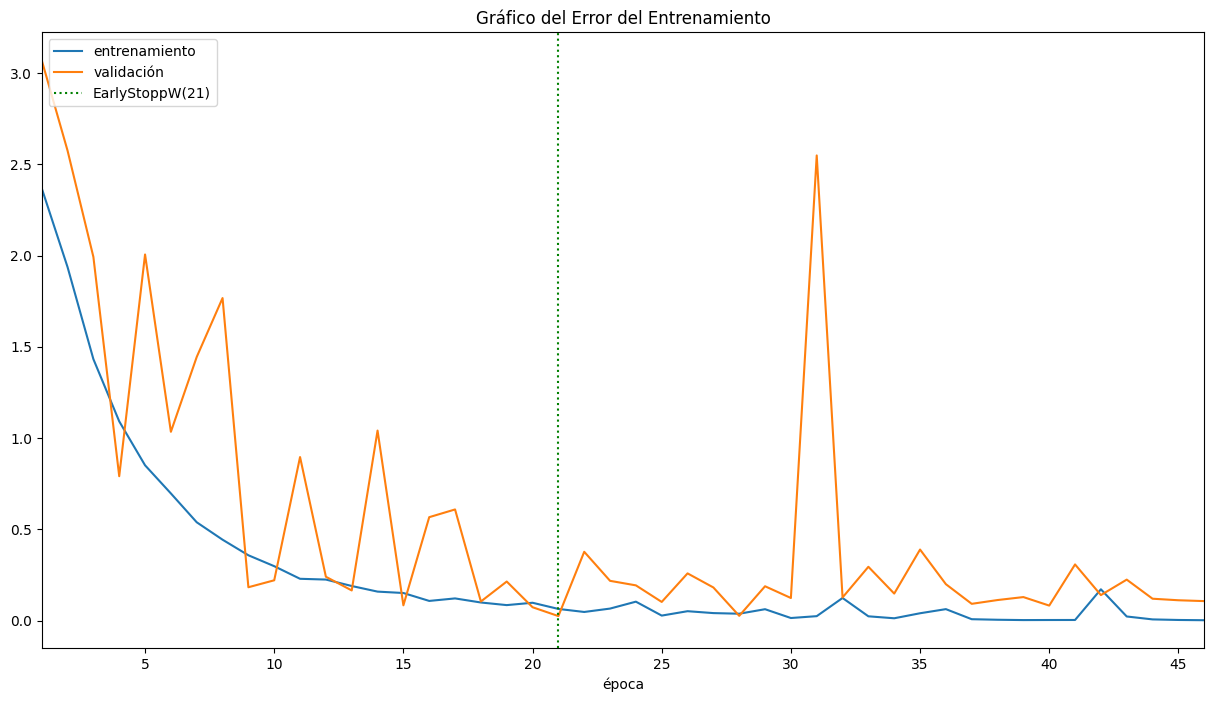

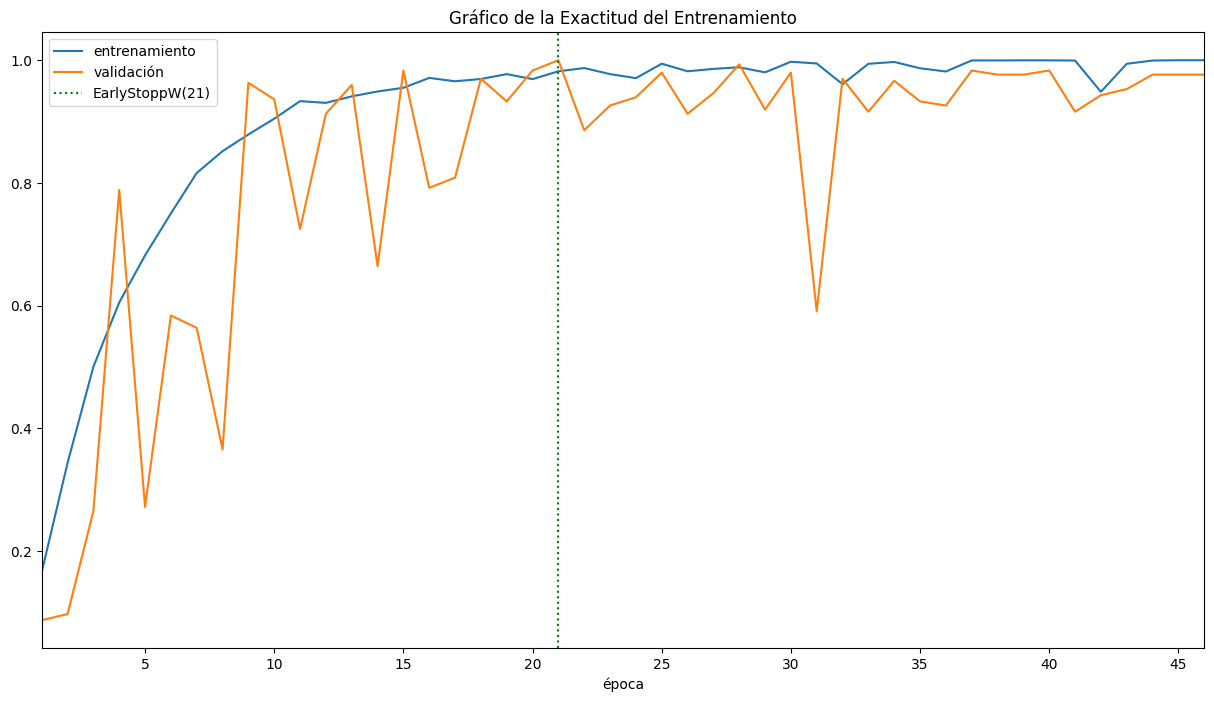

In [ ]:
#@title Mostrar Gráficos del Entrenamiento

# gráfico de LOSS
plt.figure(figsize=(15,8))
plt.plot([None] + history.history['loss']) # agrega valor None para epoch 0
plt.plot([None] + history.history['val_loss']) # agrega valor None para epoch 0
legendsLabels = ['entrenamiento', 'validación']
plt.ylabel('')
plt.xlabel('época')
plt.title('Gráfico del Error del Entrenamiento')
# resalta época de early_stopping_monitor (si se detuvo antes)
if epoch_earlyStopping is not None:
  esLabel = "EarlyStoppW("+str(epoch_earlyStopping)+")"
  plt.axvline(x=epoch_earlyStopping, color='g', linestyle=':', label=esLabel)
  legendsLabels.append( esLabel )

plt.legend(legendsLabels, loc='upper left')
plt.margins(x=0) # para que arranque en eje de coordenadas
plt.show()

# gráfico de MÉTRICAS
plt.figure(figsize=(15,8))
if esProblemaClasificacion:
  plt.plot([None] + history.history['accuracy']) # agrega valor None para epoch 0
  plt.plot([None] + history.history['val_accuracy']) # agrega valor None para epoch 0
  plt.title('Gráfico de la Exactitud del Entrenamiento')
else:
  plt.plot([None] + history.history['RootMeanSquaredError']) # agrega valor None para epoch 0
  plt.plot([None] + history.history['val_RootMeanSquaredError']) # agrega valor None para epoch 0
  plt.title('Gráfico de la Distancia Media Cuadrática Mínima del Entrenamiento')
legendsLabels = ['entrenamiento', 'validación']
plt.ylabel('')
plt.xlabel('época')
# resalta época de early_stopping_monitor (si se detuvo antes)
if epoch_earlyStopping is not None:
  plt.axvline(x=epoch_earlyStopping, color='g', linestyle=':')
  legendsLabels.append( esLabel )
plt.legend(legendsLabels, loc='upper left')
plt.margins(x=0)
plt.show()

### Evaluación del Modelo:

In [ ]:
#@title Evaluar con imágenes de entrenamiento

# genera gráfico de los errores para Estimación
def generaResumen_Estimacion(ar, tit, b=10, c=None):
    # muestra resumen
    print("\n Estadísticas para " + tit + ": ")
    print("            Mínimo: {:.4f} ".format(np.min(ar)) )
    print("            Promedio: {:.4f} ± {:.4f}".format(np.mean(ar), np.std(ar)) )
    print("            Máximo: {:.4f} ".format(np.max(ar)) )
    # muestra gráfico
    fig = plt.figure(figsize=(15,5))
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()
    return

# función auxiliar para probar el modelo entrenado para Estimación
def analizarModelo_EstimacionImagenes(datosX, datosY, predsY, mostrarImagenes=False, cantImMostrar=0):
    # procesa
    arAbs = []
    arRel = []
    imgsParaMostrar = []
    for x, r, pV in zip(datosX, datosY, predsY):
      # toma el valor estimado/predecido
      p = interpretarPredsModelo(pV, esProblemaClasificacion=False)
      # controla que sean números
      if not(math.isnan(r) or math.isnan(p)):
        # hace los cálculos
        eAbs = abs(r - p)
        if r == 0:
          eRel = (eAbs / 1)*100.0
        else:
          eRel = (eAbs / r)*100.0
        # agrega a lista para estadística
        arAbs.append(eAbs)
        arRel.append(eRel)
      # determina si agrega para mostar
      if mostrarImagenes:
        # analiza filtros apra ver si se muestra imagen
        clReal = "{:>10.4f}".format(r)
        clPred = "{:>10.4f}".format(p)
        resFiltros, imgFiltroMostrar = analizaFiltrosMostrarImg(x, clReal, clPred)
        if resFiltros and (imgFiltroMostrar is not None):
          # agrega para mostrar
          imgsParaMostrar.append( imgFiltroMostrar )
    # muestra imagenes agregadas (si hay)
    if mostrarImagenes and len(imgsParaMostrar)>0:
      mostrarImagenesResModelo(imgsParaMostrar, cantImMostrar)
    # muestra estadísticas de métricas
    generaResumen_Estimacion(arAbs, "Error Absoluto", 20, "red")
    generaResumen_Estimacion(arRel, "Error Relativo", 10, "magenta")
    return

def generaResumen_Clasificacion(classReal, classPreds, clases_labels):
    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))
    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_labels)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_labels],
        columns=['m:{:}'.format(x) for x in clases_labels]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")
    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clases_labels)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()
    return

# función auxiliar para probar el modelo entrenado en detalle
def analizarModelo_ClasificacionImagenes(datosX, datosY, predsY, clases_map=None, tipo_output_softMax=False, umbralClas=0.5, mostrarImagenes=False, cantImMostrar=0, claseFiltrar=None, tipoResFiltrarID=0):
    # hace copia de classMap por si hay clases inválidas
    if clases_map is None:
      dict_clases_map = {}
    else:
      dict_clases_map = dict(enumerate(clases_map))
    # procesa
    classPreds = []
    classReal = []
    imgsParaMostrar = []
    for x, rId, pV in zip(datosX, datosY, predsY):
      # determina nombre clase real (agrega si no existe)
      clReal, dict_clases_map = asignarClassName(rId, dict_clases_map)
      # determina el ID de clase predecida
      pId = interpretarPredsModelo(pV, esProblemaClasificacion=True,
                                  tipo_output_softMax=tipo_output_softMax, umbralClas=umbralClas)

      # asigna nombre de clase (agrega si no existe)
      clPred, dict_clases_map = asignarClassName(pId, dict_clases_map)
      # agrega a listas
      classReal.append( clReal )
      classPreds.append( clPred )
      # determina si agrega para mostar
      if mostrarImagenes:
        # analiza filtros apra ver si se muestra imagen
        resFiltros, imgFiltroMostrar = analizaFiltrosMostrarImg(x, clReal, clPred, claseFiltrar, tipoResFiltrarID)
        if resFiltros and (imgFiltroMostrar is not None):
          # agrega para mostrar
          imgsParaMostrar.append( imgFiltroMostrar )
    # muestra imagenes agregadas (si hay)
    if mostrarImagenes and len(imgsParaMostrar)>0:
      mostrarImagenesResModelo(imgsParaMostrar, cantImMostrar)
    # define lista de valores de clases
    clases_labels = list(dict_clases_map.values())
    #  muestra imágenes si corresponde
    # muestra matrices resumen
    generaResumen_Clasificacion(classReal, classPreds, clases_labels)
    return

# función que asigna nombre de clase en base a Id
# (si no existe lo agrega)
def asignarClassName(classId, dict_clases_map):
  if (classId in dict_clases_map):
    # nombre existe
    clName = dict_clases_map[classId]
  else:
    # nombre no existe, agrega
    clName = "CLASE " + str(classId) + " INVÁLIDA"
    dict_clases_map[classId] = clName
  # devuelve
  return clName, dict_clases_map

# función que interpreta resultados modelo
# de acuerdo a tipo de problem y configuración de clases
def interpretarPredsModelo(predY, esProblemaClasificacion, tipo_output_softMax=False, umbralClas=0.5):
  if esProblemaClasificacion:
    # CLASIFICACIÓN
    if tipo_output_softMax:
      ## salida SOFTMAX: determina clase predecida de acuerdo a la que tiene mayor valor
      pId = int( np.argmax(predY, axis=0) )
    else:
      ## salida SOFTMAX: determina clase predecida de acuerdo al umbral de clasificación
      auxId = predY[0]
      pId = int(auxId)
      auxRnd = abs(auxId - pId)
      if (auxRnd>umbralClas):
        # aplica umbral de clasificación
        pId += 1
    # devuelve Id de clase correspondiente
    return pId
  else:
    # ESTIMACIÓN: devuelve primer valor (RNA devuelve lista valores)
    return predY[0]


# determina si corresponde mostrar imagen por filtros
def analizaFiltrosMostrarImg(im, clReal, clPred, clFiltrar=None, tipoResFiltrarID=0):
  # determina si filtra por clase
  if (clFiltrar is None) or (clFiltrar == clReal):
    # filtra por tipo de resultado
    resClasOK = (clReal==clPred)
    if (tipoResFiltrarID==0) or \
      ((tipoResFiltrarID > 0) and resClasOK) or\
      ((tipoResFiltrarID < 0) and not(resClasOK)):
        # el titulo par aponer en la imagen
        strTitulo = 'R: ' + str(clReal) + ' / M: ' + str(clPred)
        if not resClasOK:
          strTitulo = strTitulo + "!"
        # se muestra
        return True, [strTitulo, im]
  # no se muestra
  return False, None

# muestra imágenes que correspondan
def mostrarImagenesResModelo(imgsParaMostrar, cantImMostrar):
    # determina cuantas tiene que mostrar
    if cantImMostrar >= len(imgsParaMostrar):
      # muestra todas
      eligeImAlAzar = False
      cantMostrar = len(imgsParaMostrar)
      print("\n>Detalle: ")
    else:
      # muestra al azar
      eligeImAlAzar = True
      print("\n>Detalle: (muestra "+ str(cantImMostrar) + " imágenes tomadas al azar)")
    # prepara para mostrar imagenes
    nCols = 3
    nRows = cantImMostrar // nCols
    if (nRows*nCols) < cantImMostrar:
      nRows = nRows + 1
    plt.figure(figsize=(10, 3*nRows))
    posImagen = 1
    # recorre
    for i in range(cantImMostrar):
      # elige al azar o no para mostrar
      if eligeImAlAzar:
        posIm = random.randint(1, len(imgsParaMostrar))-1
      else:
        if i >= len(imgsParaMostrar):
          break
        else:
          posIm = i
      # determina datos a mostrar
      im = imgsParaMostrar[posIm][1]
      tit = imgsParaMostrar[posIm][0]
      # muestra la imagen
      ax = plt.subplot(nRows, nCols, posImagen)
      plot_image( im )
      plt.title( tit, fontsize=9 )
      posImagen = posImagen + 1
      # saca elemento de la lista para no elegirlo al azar de nuevo
      if eligeImAlAzar:
        if len(imgsParaMostrar) > posIm:
          imgsParaMostrar.pop( posIm )
    #plt.tight_layout()
    fig = plt.gcf()
    plt.show()
    plt.close(fig)
    return

# método general para evaluar modelo
def evaluarModeloImagenes(modelo, esProblemaClasificacion, datosX, datosY, clases_map=None, tipo_output_softMax=False, umbralClas=0.5, cantImMostrar=None, rtdoFiltrar=None, claseFiltrar=None):
    global strTODOS
    # procesa los datos de entrada con el modelo
    predsY = modelo.predict(datosX, verbose=0)
    # determina cantidad a mostrar
    mostrarImagenes = True
    if (cantImMostrar == strTODOS):
      cantImMostrar = len(datosX)
    elif (cantImMostrar <= 0):
      cantImMostrar = 0
      mostrarImagenes = False
    if esProblemaClasificacion:
      # filtros para clasificación
      if (claseFiltrar is None) or (claseFiltrar == "-"):
        claseFiltrar = None
        mostrarImagenes = False
      elif (claseFiltrar == strTODOS):
        claseFiltrar = None
      if rtdoFiltrar == "Clasificación Incorrecta":
        tipoResFiltrarID = -1
      elif rtdoFiltrar == "Clasificación Correcta":
        tipoResFiltrarID = 1
      else:
        tipoResFiltrarID = 0
    # muestra resultados
    if esProblemaClasificacion:
      analizarModelo_ClasificacionImagenes(datosX, datosY, predsY,
                                   clases_map=clases_map, umbralClas=umbralClas,
                                   tipo_output_softMax=tipo_output_softMax,
                                   mostrarImagenes=mostrarImagenes, cantImMostrar=cantImMostrar,
                                   claseFiltrar=claseFiltrar, tipoResFiltrarID=tipoResFiltrarID)
    else:
      analizarModelo_EstimacionImagenes(datosX, datosY, predsY,
                                   mostrarImagenes=mostrarImagenes, cantImMostrar=cantImMostrar)

    return


# genera toda la interface para evaluar modeo
def crearUI_evaluarModelo(clDefecto, clases, funcionCambiaSeleccion, esProblemaClasificacion=True, mostrarUmbralClasif=False):
  # auxiliar para que muestre bien la descripción
  style_3D = {'description_width': 'initial'}
  childrenList = []
  # slide para definir umbral de clasificación
  slider_umbral = widgets.FloatSlider(
      value=50,
      min=0,
      max=100.0,
      step=1.0,
      description='Umbral de Clasificación: ',
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True,
      style=style_3D,
      readout_format='.1f',
  )
  if esProblemaClasificacion and mostrarUmbralClasif:
    childrenList.append( slider_umbral )
  # combo para filtrar por clase
  seleccion_CLASES = [ ]
  seleccion_CLASES.extend( clases )
  seleccion_CLASES.sort()
  if clDefecto not in seleccion_CLASES:
    seleccion_CLASES.append( clDefecto )
  combo_clase = widgets.Dropdown(
      options = seleccion_CLASES,
      value = clDefecto,
      description = 'Filtrar por clase:',
      style=style_3D,
      disabled = False,
  )
  if esProblemaClasificacion:
    childrenList.append( combo_clase )
  # combo para filtrar por resultado
  selecc_resutado = [ "Clasificación Incorrecta", "Clasificación Correcta" ]
  if clDefecto not in selecc_resutado:
    selecc_resutado.append( clDefecto )
  combo_resultado = widgets.Dropdown(
      options = selecc_resutado,
      value = selecc_resutado[0],
      description = 'Filtrar por resultado:',
      style=style_3D,
      disabled = False,
  )
  if esProblemaClasificacion:
    childrenList.append( combo_resultado )
  # prepara combo para filtrar por cantidad
  selecc_cantidad = [ 3 ]
  selecc_cantidad.extend( range(6, 252, 9) )
  if clDefecto not in selecc_cantidad:
    selecc_cantidad.append( clDefecto )
  combo_cantidad = widgets.Dropdown(
      options = selecc_cantidad,
      value = 6,
      description = 'Mostrar N imágenes al azar:',
      style=style_3D,
      disabled = False,
  )
  childrenList.append( combo_cantidad )
  # agrega contenedores
  eval_ui = widgets.GridBox(children=childrenList,
          layout=Layout(width='100%')
        )
  eval_out = widgets.interactive_output(funcionCambiaSeleccion, {'cantMostrar':combo_cantidad,
                                                                 'rtdoFiltrar': combo_resultado,
                                                                 'claseFiltrar':combo_clase,
                                                                 'umbralClas':slider_umbral})
  return eval_ui, eval_out


# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(cantMostrar, rtdoFiltrar, claseFiltrar, umbralClas):
    global esProblemaClasificacion, tipo_output_softMax
    global model
    global x_train, y_train,  CLASES
    # prueba con los datos de entrenamiento
    print("\n*** Resultados con datos de Entrenamiento: ")
    evaluarModeloImagenes(model, esProblemaClasificacion,
                  datosX=x_train, datosY=y_train, clases_map=CLASES,
                  tipo_output_softMax=tipo_output_softMax,
                  umbralClas=umbralClas/100.0,
                  cantImMostrar=cantMostrar, rtdoFiltrar=rtdoFiltrar, claseFiltrar=claseFiltrar)


# muestra la interface con entrenamiento
strTODOS = "TODOS"
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModelo(clDefecto=strTODOS,
                                                                  clases=CLASES,
                                                                  funcionCambiaSeleccion=cambiaSeleccion_clase_evaluar_imEntrenamiento,
                                                                  esProblemaClasificacion=esProblemaClasificacion,
                                                                  mostrarUmbralClasif=(esProblemaClasificacion and not(tipo_output_softMax)))
display(ev_entrenamiento_ui, ev_entrenamiento_out)
print("")



GridBox(children=(Dropdown(description='Filtrar por clase:', index=12, options=('Command Ships', 'Heavy Ships'…

Output()

In [ ]:
#@title Evaluar con imágenes de prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imPrueba(cantMostrar, rtdoFiltrar, claseFiltrar, umbralClas):
    global esProblemaClasificacion, tipo_output_softMax
    global model
    global x_test, y_test,  CLASES
    # prueba con los datos de entrenamiento
    print("\n*** Resultados con datos de Prueba: ")
    evaluarModeloImagenes(model, esProblemaClasificacion,
                  datosX=x_test, datosY=y_test, clases_map=CLASES,
                  tipo_output_softMax=tipo_output_softMax,
                  umbralClas=umbralClas/100.0,
                  cantImMostrar=cantMostrar, rtdoFiltrar=rtdoFiltrar, claseFiltrar=claseFiltrar)



# muestra la interface con prueba
ev_prueba_ui, ev_prueba_out = crearUI_evaluarModelo(clDefecto=strTODOS,
                                                    clases=CLASES,
                                                    funcionCambiaSeleccion=cambiaSeleccion_clase_evaluar_imPrueba,
                                                    esProblemaClasificacion=esProblemaClasificacion,
                                                    mostrarUmbralClasif=(esProblemaClasificacion and not(tipo_output_softMax)))
display(ev_prueba_ui, ev_prueba_out)
print("")


GridBox(children=(Dropdown(description='Filtrar por clase:', index=12, options=('Command Ships', 'Heavy Ships'…

Output()

### Exportar el Modelo:

In [ ]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/demosColab/demoStarWars/modelos/ImagConvNet'  #@param {type:"string"}

if guardar_modelo:

    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_model = path_modelo+"/model.keras"
    model.save(fn_model)
    print("\n-Modelo guardado en ", fn_model,"\n")

    if ("IMAGE_SHAPE" in locals()) and (IMAGE_SHAPE is not None):
      fn_imageShape = path_modelo+"/IMAGE_SHAPE.txt"
      with open(fn_imageShape, 'w') as f:
        for i in IMAGE_SHAPE:
          f.write(str(i)+"\n")
      print("\n-IMAGE_SHAPE para cargar las imágenes guardado en ", path_modelo,"\n")


    if ("CLASES" in locals()) and (CLASES is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(CLASES)):
          f.write(str(i)+":"+str(CLASES[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", path_modelo,"\n")

else:
    print("\n-Modelo no guardado.")